In [8]:
import csv
import gym
from gym import spaces
import numpy as np

In [9]:
tickers = ["AAPL", "AMZN", "GOOGL", "MSFT", "NVDA", "TSLA"]

data = {i: {t: float(row[t]) for t in tickers} \
    for i, row in enumerate(csv.DictReader( \
    open("nasdaq_stock_prices.csv", mode='r'), delimiter=','))
}

In [ ]:
class Environment(gym.Env):
    def __init__(self, data: dict, window_size: int, initial_balance: float, verbose: bool = False):
        self.current_step = 0
        self.history_prices = data
        self.current_prices = self.history_prices[self.current_step]
        self.max_steps = len(self.history_prices) - 1
        self.tickers = list(self.history_prices[0].keys())
        self.window_size = window_size

        self.initial_balance = initial_balance
        self.history_balance = {0: self.initial_balance}
        self.current_balance = self.history_balance[self.current_step]

        self.initial_shares = {t: 0 for t in self.tickers}
        self.history_shares = {0: self.initial_shares}
        self.current_shares = self.history_shares[self.current_step]

        self.initial_value = self.initial_balance
        self.history_value = {0: self.initial_value}
        self.current_value = self.history_value[self.current_step]

        self.action_space = spaces.Box(low = -1.0, high = 1.0, shape = (len(self.tickers),))
        self.observation_dimension = len(self.tickers) * (self.window_size + 1) + 2  #window of prices (n*w) + current_shares (n) + current_balance (1) + current_value (1)
        self.observation_space = spaces.Box(low = -np.inf, high = np.inf, shape = (self.observation_dimension,))

        self.done = False

        self.verbose = verbose

    def reset(self):
        self.current_step = 0

        self.history_balance = {0: self.initial_balance}
        self.current_balance = self.initial_balance

        self.history_shares = {0: self.initial_shares}
        self.current_shares = self.initial_shares

        self.initial_value = self.initial_balance
        self.history_value = {0: self.initial_value}
        self.current_value = self.initial_value
        
        self.done = False
        return self._get_state()
    
    def render(self):
        return self.history_balance, self.history_shares, self.history_value
    
    def _get_state(self):
        start = max(0, self.current_step - self.window_size)
        end = self.current_step + 1
        prices_window = [self.history_prices[i] for i in range(start, end)]
        balance_window = [self.history_balance[i] for i in range(start, end)]
        shares_window = [self.history_shares[i] for i in range(start, end)]
        value_window = [self.history_value[i] for i in range(start, end)]
        return prices_window, balance_window, shares_window, value_window
        
    def step(self, action: np.ndarray):
        if self.done:
            return self._get_state(), 0, self.done, {}

        if np.sum(action) > 1.0:
            raise ValueError(f"Invalid action: total buy fraction = {np.sum(action):.2f} > 1.0")
        
        if any([a < -1.0 for a in action]):
            raise ValueError(f"Invalid action: sell fraction < -1.0")

        for i, ticker in enumerate(self.tickers):
            act = action[i]
            if act < 0:
                shares_to_sell = self.current_shares[ticker] * (-act)
                proceeds = shares_to_sell * self.current_prices[ticker]
                self.current_balance += proceeds
                self.current_shares[ticker] -= shares_to_sell

            elif act > 0:
                amount_to_invest = self.current_balance * act
                shares_to_buy = amount_to_invest / self.current_prices[ticker]
                cost = shares_to_buy * self.current_prices[ticker]
                self.current_balance -= cost
                self.current_shares[ticker] += shares_to_buy

        previous_value = self.history_value[self.current_step]
        self.current_value = self.current_balance + sum(self.current_shares[t] * self.current_prices[t] for t in self.tickers)
        reward = self.current_value - previous_value

        if self.verbose:
            print(f"\n📈 Step: {self.current_step}")
            print(f"🟦 Prices: {[round(self.current_prices[t], 2) for t in self.tickers]}")
            print(f"💰 Balance: {self.current_balance:.2f}")
            print(f"📊 Shares: { {t: round(self.current_shares[t], 2) for t in self.tickers} }")
            print(f"📦 Value: {self.current_value:.2f}")
            print(f"🔄 Reward: {reward:.2f} (Δ from {previous_value:.2f})")
            print(f"🎯 Action taken: {np.round(action, 2)}")

        self.current_step += 1
        self.done = self.current_step >= self.max_steps

        self.current_prices = self.history_prices[self.current_step]
        self.history_balance[self.current_step] = self.current_balance
        self.history_shares[self.current_step] = self.current_shares.copy()
        self.history_value[self.current_step] = self.current_value

        return self._get_state(), reward, self.done, {}

In [42]:
from abc import ABC, abstractmethod
import numpy as np

class BaseAgent(ABC):
    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def act(self, state: np.ndarray) -> tuple[np.ndarray, int | None]:
        pass

    @abstractmethod
    def update(self, *args):
        pass

    def train(self):
        pass


In [43]:
#from agents.base_agent import BaseAgent
import numpy as np

def train_agent(agent: BaseAgent, env: Environment, episodes=1, verbose=False):
    all_rewards = []

    for ep in range(episodes):
        state = env.reset()
        agent.reset()
        done = False
        total_reward = 0

        while not done:
            action, action_id = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(action_id, reward)
            state = next_state
            total_reward += reward

        all_rewards.append(total_reward)
        if verbose:
            print(f"Épisode {ep + 1}/{episodes} — Total reward: {total_reward:.2f}")

    return all_rewards

In [ ]:
import numpy as np
#from agents.base_agent import BaseAgent

class MAB_Agent(BaseAgent):
    def __init__(self, env, epsilon=0.1):
        self.epsilon = epsilon
        self.tickers = env.tickers
        self.n_arms = len(self.tickers)

        buy_actions = np.eye(self.n_arms, dtype=np.float32)
        sell_action = -np.ones((1, self.n_arms), dtype=np.float32)
        hold_action = np.zeros((1, self.n_arms), dtype=np.float32)
        self.action_templates = np.vstack([buy_actions, sell_action, hold_action])

        self.Q = np.zeros(len(self.action_templates))
        self.N = np.zeros(len(self.action_templates))

    def reset(self):
        self.Q = np.zeros(len(self.action_templates))
        self.N = np.zeros(len(self.action_templates))

    def select_action_id(self) -> int:
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.action_templates))
        else:
            return np.argmax(self.Q)

    def act(self, state=None):
        action_id = self.select_action_id()
        action = self.action_templates[action_id]
        return action, action_id

    def update(self, action_id, reward):
        self.N[action_id] += 1
        alpha = 1 / self.N[action_id]
        self.Q[action_id] += alpha * (reward - self.Q[action_id])

In [49]:
environment = Environment(data, 10, initial_balance=1000, verbose=True)
agent_optimal = MAB_Agent(environment, epsilon=0.1)
results_mab_agent_optimal = train_agent(agent_optimal, environment, episodes=2, verbose=True)


📈 Step 0
🟦 Prices: [72.72, 94.9, 68.11, 153.32, 5.97, 28.68]
💰 Balance: 0.00
📊 Shares: {'AAPL': 13.75, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'NVDA': 0, 'TSLA': 0}
📦 Value: 1000.00
🔄 Reward: 0.00 (Δ from 1000.00)
🎯 Action taken: [1. 0. 0. 0. 0. 0.]

📈 Step 1
🟦 Prices: [72.01, 93.75, 67.75, 151.41, 5.88, 29.53]
💰 Balance: 0.00
📊 Shares: {'AAPL': 13.75, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'NVDA': 0, 'TSLA': 0}
📦 Value: 990.28
🔄 Reward: -9.72 (Δ from 1000.00)
🎯 Action taken: [1. 0. 0. 0. 0. 0.]

📈 Step 2
🟦 Prices: [72.58, 95.14, 69.56, 151.81, 5.9, 30.1]
💰 Balance: 0.00
📊 Shares: {'AAPL': 13.75, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'NVDA': 0, 'TSLA': 0}
📦 Value: 998.17
🔄 Reward: 7.89 (Δ from 990.28)
🎯 Action taken: [1. 0. 0. 0. 0. 0.]

📈 Step 3
🟦 Prices: [72.24, 95.34, 69.42, 150.42, 5.97, 31.27]
💰 Balance: 0.00
📊 Shares: {'AAPL': 13.75, 'AMZN': 0.0, 'GOOGL': 0, 'MSFT': 0, 'NVDA': 0, 'TSLA': 0}
📦 Value: 993.47
🔄 Reward: -4.69 (Δ from 998.17)
🎯 Action taken: [0. 1. 0. 0. 0. 0.]

📈 Step 4
🟦 Prices: 

In [46]:
results_mab_agent_optimal

[1362.734392049556, 2356.4023463172025]

Épisode 1/100 — Total reward: 0.00
Épisode 2/100 — Total reward: 1000.00
Épisode 3/100 — Total reward: 2000.00
Épisode 4/100 — Total reward: 3000.00
Épisode 5/100 — Total reward: 4000.00
Épisode 6/100 — Total reward: 5000.00
Épisode 7/100 — Total reward: 6000.00
Épisode 8/100 — Total reward: 7000.00
Épisode 9/100 — Total reward: 8000.00
Épisode 10/100 — Total reward: 9000.00
Épisode 11/100 — Total reward: 10000.00
Épisode 12/100 — Total reward: 11000.00
Épisode 13/100 — Total reward: 12000.00
Épisode 14/100 — Total reward: 13000.00
Épisode 15/100 — Total reward: 14000.00
Épisode 16/100 — Total reward: 15000.00
Épisode 17/100 — Total reward: 16000.00
Épisode 18/100 — Total reward: 17000.00
Épisode 19/100 — Total reward: 18000.00
Épisode 20/100 — Total reward: 19000.00
Épisode 21/100 — Total reward: 20000.00
Épisode 22/100 — Total reward: 21000.00
Épisode 23/100 — Total reward: 22000.00
Épisode 24/100 — Total reward: 23000.00
Épisode 25/100 — Total reward: 24000.00
Épisode 26/100 — Total

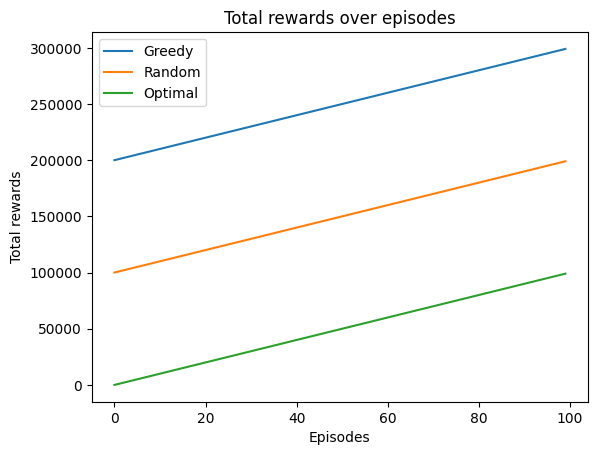

Greedy:  [199999.99999999983, 200999.99999999983, 201999.99999999983, 202999.9999999998, 203999.9999999998, 204999.9999999998, 205999.9999999998, 206999.9999999998, 207999.99999999977, 208999.99999999977, 209999.99999999977, 210999.99999999977, 211999.99999999977, 212999.99999999977, 213999.99999999977, 214999.99999999977, 215999.99999999977, 216999.99999999974, 217999.99999999974, 218999.99999999974, 219999.99999999974, 220999.99999999974, 221999.99999999974, 222999.99999999974, 223999.99999999974, 224999.99999999974, 225999.99999999974, 226999.99999999974, 227999.9999999997, 228999.9999999997, 229999.9999999997, 230999.9999999997, 231999.9999999997, 232999.9999999997, 233999.9999999997, 234999.9999999997, 235999.9999999997, 236999.9999999997, 237999.99999999968, 238999.99999999968, 239999.9999999997, 240999.9999999997, 241999.9999999997, 242999.99999999968, 243999.99999999968, 244999.99999999968, 245999.99999999968, 246999.99999999968, 247999.99999999968, 248999.99999999968, 249999.9

In [20]:
import matplotlib.pyplot as plt

environment = Environment(data, 10, initial_balance=1000)
agent_optimal = MAB_Agent(environment, epsilon=0.1)
agent_random = MAB_Agent(environment, epsilon=1.0)
agent_greedy = MAB_Agent(environment, epsilon=0.0)
results_mab_agent_optimal = train_agent(agent_optimal, environment, episodes=100, verbose=True)
results_mab_agent_random = train_agent(agent_random, environment, episodes=100, verbose=True)
results_mab_agent_greedy = train_agent(agent_greedy, environment, episodes=100, verbose=True)

plt.plot(results_mab_agent_greedy, label="Greedy")
plt.plot(results_mab_agent_random, label="Random")
plt.plot(results_mab_agent_optimal, label="Optimal")
plt.legend()
plt.title("Total rewards over episodes")
plt.xlabel("Episodes")
plt.ylabel("Total rewards")
plt.show()

print("Greedy: ", results_mab_agent_greedy)
print("Random: ", results_mab_agent_random)
print("Optimal: ", results_mab_agent_optimal)